# Boxplot of DE junctions

In [1]:
library(ggpubr)
library(ggplot2)
library(tidyverse)
suppressMessages(library(data.table))

Loading required package: ggplot2

-- Attaching packages --------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
ggplot_save <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


subset_deg <- function(fn, thres){
    jt = fread(fn) %>% rename(Feature='V1') %>% 
        filter(adj.P.Val < thres) %>% 
        select(Feature, ensemblID, Symbol, logFC, adj.P.Val)
    return(jt)
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Load DEG annotation

In [3]:
fn1 = '../../_m/junctions/diffExpr_interaction_full.txt'
fn2 = '../../_m/junctions/diffExpr_maleVfemale_full.txt'
fn3 = '../../_m/junctions/diffExpr_szVctl_full.txt'
juncs = subset_deg(fn1, 0.05)
sex = subset_deg(fn2, 1)
sz = subset_deg(fn3, 1)

In [6]:
sz %>% head(2)

Feature,ensemblID,Symbol,logFC,adj.P.Val
<chr>,<chr>,<chr>,<dbl>,<dbl>
chr21:8401646-8443413(-),,,3.5443787,0.004160353
chr15:78030171-78044899(-),ENSG00000167202,TBC1D2B,0.4520952,0.016759954


In [7]:
df = juncs %>% 
        inner_join(sex, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Sex")) %>%
        inner_join(sz, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Diagnosis"))
df = add_symnum(df)
df

Feature,ensemblID,Symbol,logFC,adj.P.Val,logFC_Sex,adj.P.Val_Sex,logFC_Diagnosis,adj.P.Val_Diagnosis,FDR,p.signif
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr14:49853786-49862553(-),,,6.843164,0.002006684,-3.0349586,2.152121e-04,-4.270336,0.1537064,0.0020,**
chr18:31592940-31592993(+),,,3.726332,0.003890647,-1.6047482,1.469915e-02,-2.155212,0.2285224,0.0039,**
chr21:8219273-8402302(-),,,-3.263341,0.003890647,1.6562878,3.744327e-05,2.067152,0.1617772,0.0039,**
chrX:140784309-140784456(+),,,3.178270,0.046789174,-0.9984352,4.105778e-01,-2.304170,0.1537064,0.0468,*


## Load phenotypes

In [8]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/hippo_phenotypes.csv'
pheno = fread(pheno_file) %>% column_to_rownames(var='V1') %>% 
    mutate_if(is.character, as.factor)
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Dx) <- c("CTL", "SZ")
pheno %>% head(2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,Br2063,R11135,HIPPO,5.9,18.77,Male,CAUC,CTL
2,Br2582,R11137,HIPPO,9.2,41.44,Male,CAUC,CTL


## Load residualized expression

In [10]:
res_file = '../../_m/junctions/residualized_expression.tsv'
resdf = fread(res_file) %>% 
    column_to_rownames(var="V1") %>% t
resdf = as.data.frame(resdf) %>% 
    rownames_to_column() %>% 
    rename(RNum=rowname) %>% 
    select(RNum, df$Feature)
resdf %>% head(2)

Warning message in fread(res_file):
"Detected 376 column names but the data has 377 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,RNum,chr14:49853786-49862553(-),chr18:31592940-31592993(+),chr21:8219273-8402302(-),chrX:140784309-140784456(+)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,R11135,0.2843588,1.657791,1.3502649,-1.4198097
2,R11137,0.4003428,1.490807,-0.4105825,-0.7794243


## Merge data

In [11]:
jj = pheno %>% 
    inner_join(resdf, by='RNum')
jj %>% dim
jj %>% head(2)

[1] 376  12

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,chr14:49853786-49862553(-),chr18:31592940-31592993(+),chr21:8219273-8402302(-),chrX:140784309-140784456(+)
,<fct>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,Br2063,R11135,HIPPO,5.9,18.77,Male,CAUC,CTL,0.2843588,1.657791,1.3502649,-1.4198097
2,Br2582,R11137,HIPPO,9.2,41.44,Male,CAUC,CTL,0.4003428,1.490807,-0.4105825,-0.7794243


In [12]:
dft = jj %>% pivot_longer(-c(BrNum, RNum, Region, RIN, Age, Sex, Race, Dx), 
                          names_to="Feature", values_to="Res") %>% 
    inner_join(df, by="Feature") %>% mutate_at("Feature", as.factor)
dft %>% head(2)

BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,Feature,Res,ensemblID,Symbol,logFC,adj.P.Val,logFC_Sex,adj.P.Val_Sex,logFC_Diagnosis,adj.P.Val_Diagnosis,FDR,p.signif
<fct>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Br2063,R11135,HIPPO,5.9,18.77,Male,CAUC,CTL,chr14:49853786-49862553(-),0.2843588,,,6.843164,0.002006684,-3.034959,0.0002152121,-4.270336,0.1537064,0.0020,**
Br2063,R11135,HIPPO,5.9,18.77,Male,CAUC,CTL,chr18:31592940-31592993(+),1.6577909,,,3.726332,0.003890647,-1.604748,0.0146991473,-2.155212,0.2285224,0.0039,**


Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


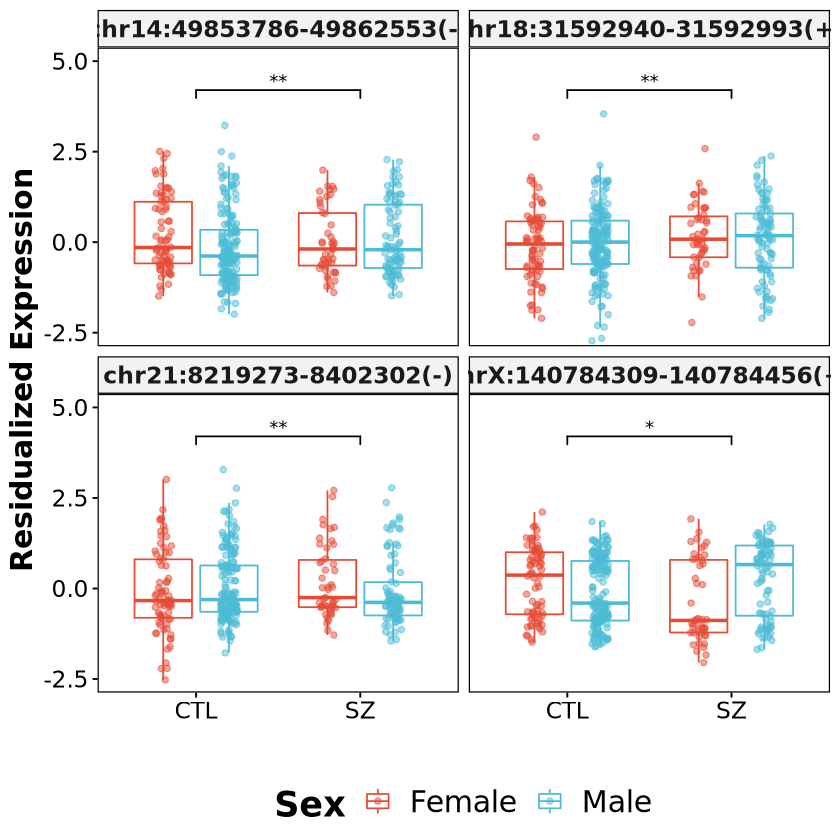

In [13]:
tmp = df %>% mutate(group1='CTL', group2='SZ', y_pos=4.2)

bxp <- ggboxplot(dft, x="Dx", y="Res", color="Sex", add='jitter',
                 panel.labs.font=list(face='bold', size = 14),
                 facet.by=c("Feature"), palette="npg", xlab='', 
                 ylim=c(-2.5, 5), ylab='Residualized Expression', 
                 add.params=list(alpha=0.5), legend="bottom", 
                 outlier.shape=NA) +
        geom_signif(data=tmp, 
                    aes(xmin=group1, xmax=group2, 
                        annotations=p.signif, y_position=y_pos), 
                    manual=TRUE) + 
        font("xy.title", size=18, face="bold") + font("xy.text", size=14) + 
        font("legend.title", size=21, face="bold") + font("legend.text", size=18)
         
bxp

In [14]:
ggplot_save(bxp, 'junc_interaction', 8, 8)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()